# K-means with Hive

Gabriel Ducrocq

In [357]:
from boto.emr.connection import EmrConnection
import boto
import paramiko
import os
import time
import pandas as pd
%matplotlib inline 

The purpose of this project is to implement a distributed K-means algorithm using Hive. In order to do that, we set up an Amazon EMR cluster of three servers: one master node and two slaves nodes. The Amazon Elastic MapReduce offer has a big advantage over the Amazon EC2 one: no need to spend time installing Hadoop and Hive, eveything is already done. As soon as you have loaded your dataset on the cluster, you can run some analysis.
We won't cover the details of the k-means algorithm here. It is very well-known and very well described in the litterature and on the internet. For example on wikipedia: https://en.wikipedia.org/wiki/K-means_clustering.<br/>
The dataset we are using is originally designed for a classification task: researchers randomly sampled R, G and B value from the face images of many different persons (young, middle-aged, old, white, black, asian, male and female). Some of these value are sampled from skin, other are not. The proposed task is to identify which of the samples correspond to skin and which does not.

We use this dataset to try an implementation of k-means. More precisely we set the number of cluster as 2. We made this choice for several reasons: first, we have a lighter code. Second, as there are only two classes - skin and non skin - we are curious to see if the algorithm will partition the space in a relevant way considering these two classes.

## Creation of Database

We first download the data located at  https://archive.ics.uci.edu/ml/machine-learning-databases/00229/Skin_NonSkin.txt and then we create the database containing a table with the data of interest. Finally we check that the data were correctly loaded:

![title](ClusterEMR/downloadingData.png)

![title](ClusterEMR/setupstep.png)

The next step is to write the script we will use as the foundation of our algorithm. The first script is used to initialize the algorithm and the second one is the core of it.

```sql

USE skin_db;

-- Comuting the mean and variance of teach feature
CREATE TABLE mean STORED AS TEXTFILE
AS SELECT avg(B) AS avgB, avg(G) AS avgG, avg(R) AS avgR FROM skin LIMIT 1;

CREATE TABLE variance STORED AS TEXTFILE
AS SELECT variance(B) AS varB, variance(G) AS varG, variance(R) AS varR FROM skin LIMIT 1;

-- Normalization step
CREATE VIEW skin_centered AS
SELECT B-avgB AS B, G-avgG AS G, R-avgR AS R FROM skin CROSS JOIN mean;

CREATE VIEW skin_normalized AS
SELECT B/varB AS B, G/varG AS G, R/varR AS R FROM skin_centered CROSS JOIN variance;

-- Random initialization of the clusters and computation of the 
-- the two centroids
CREATE TABLE  clusters STORED AS TEXTFILE 
AS SELECT ROW_NUMBER() OVER() as id,  B, G, R, round(rand()) as cluster FROM skin_normalized;

CREATE VIEW centroids 
AS SELECT avg(B) AS B, avg(G) AS G, avg(R) AS R, cluster FROM clusters GROUP BY cluster;

CREATE TABLE centroid0 STORED AS TEXTFILE
AS SELECT B, G, R, cluster FROM centroids WHERE cluster == 0.0;

CREATE TABLE centroid1 STORED AS TEXTFILE
AS SELECT B, G, R, cluster FROM centroids WHERE cluster == 1.0;

CREATE TABLE differences STORED AS TEXTFILE
AS SELECT 0 FROM skin LIMIT 1;

DROP VIEW skin_centered;
DROP VIEW skin_normalized;
DROP VIEW centroids;
```

We write this code in the init_kmeans.sql file and send it to the cluster through a ssh connection:

In [558]:
os.system("scp -i HiveKmeans.pem init_kmeans.sql hadoop@ec2-35-166-207-225.us-west-2.compute.amazonaws.com:scripts/init_kmeans.sql")

0

We write the core of the algorithm. We will use it to iterate and compute the successive centroids and clusters.

```sql
USE skin_db;

-- Computation of the distances to the centroids and attribution to the new clusters
CREATE VIEW obs_and_centroids AS 
SELECT first_join.id AS id, first_join.B AS B, first_join.G AS G, first_join.R AS R, first_join.c0B AS c0B, first_join.c0G AS c0G, first_join.c0R AS c0R, centroid1.B AS c1B, centroid1.G AS c1G, centroid1.R AS c1R FROM
	(SELECT clusters.id AS id, clusters.B AS B, clusters.G AS G, clusters.R AS R, centroid0.B AS c0B,centroid0.G AS c0G, centroid0.R AS c0R  FROM clusters CROSS JOIN centroid0) first_join CROSS JOIN centroid1;

CREATE VIEW distances AS
SELECT id AS id, B, G, R, sqrt(pow(B - c0B, 2)+pow(G - c0G, 2)+pow(R - c0R, 2)) AS dist_c0, sqrt(pow(B - c1B, 2)+pow(G - c1G, 2)+pow(R - c1R, 2)) AS dist_c1 FROM obs_and_centroids;

CREATE VIEW  new_clusters AS
SELECT id AS id, B, G, R, IF(dist_c0 < dist_C1, 0, 1) AS cluster FROM distances;


-- Computation of the number of points who changed cluster
INSERT OVERWRITE DIRECTORY 'differences'
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
SELECT SUM(IF(clusters.cluster=new_clusters.cluster, 0, 1)) AS is_diff FROM
clusters LEFT OUTER JOIN new_clusters 
ON new_clusters.id=clusters.id LIMIT 1;

-- Saving the new clusters and computing the new centroids
INSERT OVERWRITE TABLE clusters
SELECT * FROM new_clusters;

CREATE VIEW centroids AS
SELECT avg(B) AS B, avg(G) AS G, avg(R) AS R, avg(cluster) AS cluster FROM clusters GROUP BY cluster;

INSERT OVERWRITE TABLE centroid0
SELECT * FROM centroids WHERE cluster == 0.0;

INSERT OVERWRITE TABLE centroid1
SELECT * FROM centroids WHERE cluster == 1.0;


DROP VIEW centroids;
DROP VIEW distances;
DROP VIEW obs_and_centroids;
DROP VIEW new_clusters;
```

We write this code in the core_algorithm.sql file and send it to the cluster through a ssh connection:

In [559]:
os.system("scp -i HiveKmeans.pem core_algorithm.sql hadoop@ec2-35-166-207-225.us-west-2.compute.amazonaws.com:scripts/core_algorithm.sql")

0

Finally, the last Hive script we will need to run is the postprocessing one. It will un-normalize the data and export it with the cluster attributions. As we do that, we also export the centroids of these clusters

```sql
USE skin_db;

CREATE VIEW unreducted AS
SELECT B*varB AS B, G*varG AS G, R*varR AS R, cluster AS cluster
FROM clusters CROSS JOIN variance;

INSERT OVERWRITE DIRECTORY 'final_cluster'
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
SELECT B+avgB AS B, G+avgG AS G, R+avgR AS R, cluster AS cluster 
FROM unreducted CROSS JOIN mean;

INSERT OVERWRITE DIRECTORY 'centroid0'
ROW FORMAT DELIMITED 
FIELDS TERMINATED BY ','
SELECT * FROM centroid0;

INSERT OVERWRITE DIRECTORY 'centroid1'
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
SELECT * FROM centroid1;

DROP VIEW unreducted;
```

In the same way, we send this file - postprocessing.sql - to the cluster using the following command:

In [600]:
os.system("scp -i HiveKmeans.pem postprocessing.sql hadoop@ec2-35-166-207-225.us-west-2.compute.amazonaws.com:scripts/postprocessing.sql")

0

We now move the scripts into a folder from which they can be run using boto:

In [190]:
ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
key = paramiko.RSAKey.from_private_key_file("HiveKmeans.pem")
ssh.connect('ec2-35-166-207-225.us-west-2.compute.amazonaws.com', username = "hadoop", pkey = key)
stdin, stdout, stderr = ssh.exec_command("cd scripts ; sudo cp init_kmeans.sql /usr/share/aws/emr/scripts/init_kmeans.sql ; sudo cp core_algorithm.sql /usr/share/aws/emr/scripts/core_algorithm.sql ; sudo cp postprocessing.sql /usr/share/aws/emr/scripts/postprocessing.sql")
print(stderr.readlines())

## Connection to the hadoop cluster

We now connect to the cluster using boto. This API allows us to remotely manage our EMR cluster from the python notebook. Setup instructions and documentation can be found there: http://boto.cloudhackers.com/en/latest/. Note that we do not use boto instead of boto3 so we can submit Hive jobs much more easily.

In [236]:
boto.set_stream_logger('paws', level = 0)
emr = boto.emr.connect_to_region("us-west-2", debug = 0)

We get the id of our cluster and add it three steps: the initialisation one,the core one and the postprocessing one.

In [237]:
cluster_id = emr.list_clusters(cluster_states="WAITING").clusters[0].id
init_step = boto.emr.step.HiveStep("Initialization Step", "/usr/share/aws/emr/scripts/init_kmeans.sql")
core_step = boto.emr.step.HiveStep("Core step", "/usr/share/aws/emr/scripts/core_algorithm.sql")
postprocessing = boto.emr.step.HiveStep("PostProcessing step", "/usr/share/aws/emr/scripts/postprocessing.sql")

### Initialization step

Time to initialize the tables:

In [249]:
init_job = emr.add_jobflow_steps(cluster_id, init_step)

In [251]:
step = emr.list_steps(cluster_id).steps[0]
print(step.status.state)

COMPLETED


### Iterations

We start to iterate. Note that there are two stopping critera: 
- a limited number of iterations
- the number of point changing cluster between two steps being 0.

In [252]:
MAX_ITER = 20
ITER = 1
history_diffs = []

In [253]:
while ITER < MAX_ITER+1:
    job = emr.add_jobflow_steps(cluster_id, core_step)
    nb_diff = None
    failed = False
    while True:
        time.sleep(3)
        step = emr.list_steps(cluster_id).steps[0]
        if step.status.state == "FAILED":
            print("JOB FAILED !")
            failed = True
            break
        elif step.status.state == "COMPLETED":
            print("JOB COMPLETED")
            stdin, stdout, stderr = ssh.exec_command("hdfs dfs -get differences/000000_0 differences.txt")
            time.sleep(10)
            ssh.exec_command("hdfs dfs -rmr differences")
            var =os.system("scp -i HiveKmeans.pem hadoop@ec2-35-166-207-225.us-west-2.compute.amazonaws.com:differences.txt ~/ClusterEMR/differences.txt")
            stdin_rm, stdout_rm, stderr_rm = ssh.exec_command("rm differences.txt")
            with open("ClusterEMR/differences.txt", "r") as file:
                nb_diff = int(file.read())
                history_diffs.append(nb_diff)

            print("Iteration "+str(ITER)+" done !")
            break
    
    ITER += 1
    if nb_diff == 0 or failed == True:
        break     
        

JOB COMPLETED
Iteration 1 done !
JOB COMPLETED
Iteration 2 done !
JOB COMPLETED
Iteration 3 done !
JOB COMPLETED
Iteration 4 done !
JOB COMPLETED
Iteration 5 done !
JOB COMPLETED
Iteration 6 done !
JOB COMPLETED
Iteration 7 done !
JOB COMPLETED
Iteration 8 done !
JOB COMPLETED
Iteration 9 done !
JOB COMPLETED
Iteration 10 done !
JOB COMPLETED
Iteration 11 done !
JOB COMPLETED
Iteration 12 done !


The algorithm stops after twelve iterations, which means that every points stayed in the same cluster between the 11th and the 12th iteration. Now we export the table containing the new cluters, we get it into the local file system and copy it on our local machine:

In [260]:
job_postprocess = emr.add_jobflow_steps(cluster_id, postprocessing)

In [267]:
step_postprocess = emr.list_steps(cluster_id).steps[0]
print(step_postprocess.status.state)

COMPLETED


In [268]:
stdin_fc, stdout_fc, stderr_fc = ssh.exec_command("hdfs dfs -get final_cluster/000000_0 final_cluster.txt")

In [269]:
stdin, stdout, stderr = ssh.exec_command("ls")
print(stdout.readlines())

['downloads\n', 'final_cluster.txt\n', 'scripts\n']


In [270]:
os.system("scp -i HiveKmeans.pem hadoop@ec2-35-166-207-225.us-west-2.compute.amazonaws.com:final_cluster.txt ~/ClusterEMR/final_cluster.txt")

0

### Data Viz

##### Percentage of changing points

Below is the plot of the percentage of points who switched cluster at each step:

In [287]:
nb_points = skin.shape[0]
diffs_pct = [elt/nb_points for elt in history_diffs]

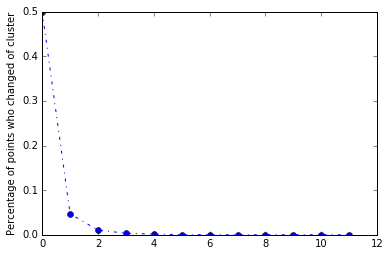

In [289]:
import matplotlib.pyplot as plt
plt.plot(diffs_pct, 'bo', linestyle = '-.')
plt.ylabel("Percentage of points who changed of cluster")

The percentage of changing points decreases very quickly: there is a big drop between the first and the second iteration. We could stop the algorithm earlier: after 4 iteration, only a small percentage of points change. The impact on the custer is minimal and unnecessary for a global interpretation.

##### Clusters visualization

In [350]:
skin = pd.read_csv("ClusterEMR/final_cluster.txt", header = None)
skin.columns = ["b", "g", "r", "cluster"]

In [351]:
C0 = np.mean(skin[skin.cluster==0])
C1 = np.mean(skin[skin.cluster==1])
skin = skin.drop_duplicates()

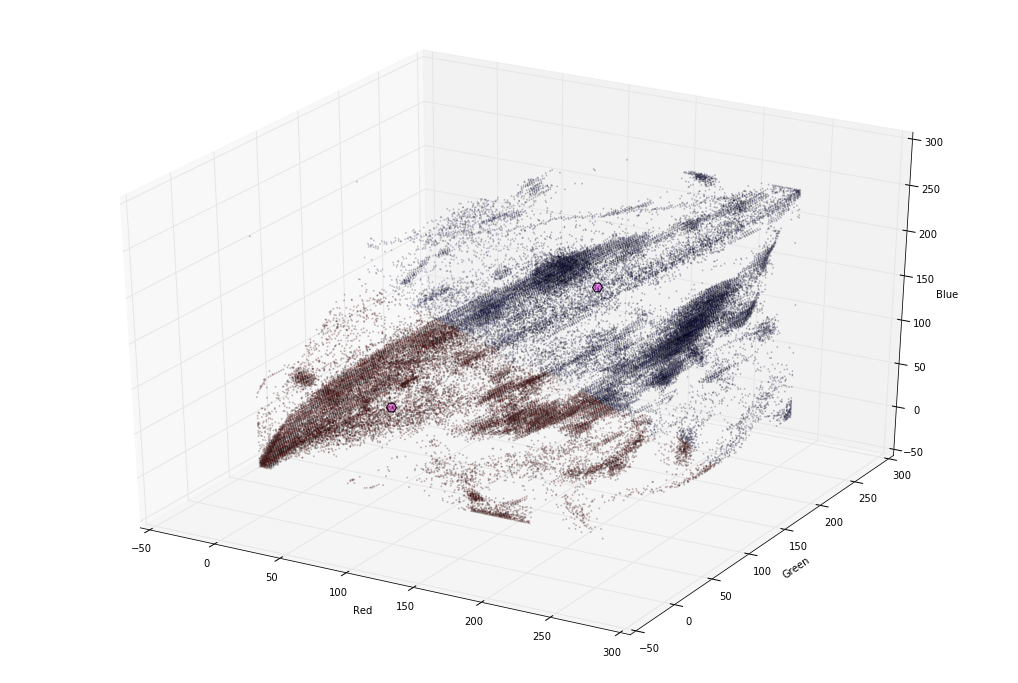

In [352]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(111, projection='3d')
for c, m, cluster in [('r', 'o', 0), ('b', '^', 1)]:
    xs = skin.r[skin.cluster==cluster]
    ys = skin.g[skin.cluster==cluster]
    zs = skin.b[skin.cluster==cluster]
    ax.scatter(xs, ys, zs, c=c, marker=m, alpha = 0.2, s = 1)
ax.scatter(C0.r, C0.g, C0.b, c='violet', marker='H', s=100)
ax.scatter(C1.r, C1.g, C1.b, c='violet', marker='H', s=100)
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')

The algorithm, initialized with K = 2, actually separates the dataset in two clusters. We can wonder if this was the two "optimal" clusters. Below we make the same plot using the real labels - skin/non skin - instead of the clusters given by the algorithm. 

In [353]:
df = pd.read_csv("Skin_NonSkin.txt", sep ='\t', header = None)
df.columns = ["b", "g", "r", "skin"]

In [354]:
df.head()

,b,g,r,skin
0,74,85,123,1
1,73,84,122,1
2,72,83,121,1
3,70,81,119,1
4,70,81,119,1


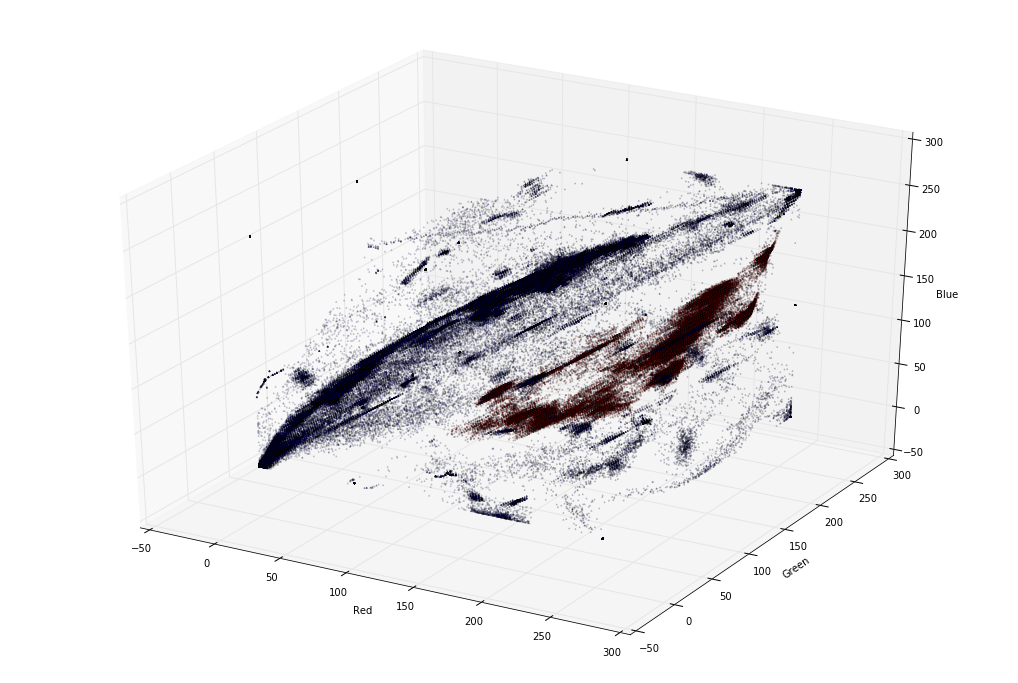

In [355]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(111, projection='3d')
for c, m, cluster in [('r', 'o', 1), ('b', '^', 2)]:
    xs = df.r[df.skin==cluster]
    ys = df.g[df.skin==cluster]
    zs = df.b[df.skin==cluster]
    ax.scatter(xs, ys, zs, c=c, marker=m, alpha = 0.2, s = 1)
#ax.scatter(C0.r, C0.g, C0.b, c='violet', marker='H', s=100)
#ax.scatter(C1.r, C1.g, C1.b, c='violet', marker='H', s=100)
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')

Comparing the two scatter plot, it is obvious that the algorithm does not discriminate the groups of interest. But a clustering algorithm is not a classification method: the k-means algorithm is unspervised learning method and thus does not take into account the variable of interest - skin/non skin. Hence, this method can't yields results as good as a classification method, e.g a Support Vector Machine.